In [1]:
using LinearAlgebra
using Plots
using LaTeXStrings
using ColorSchemes
using ForwardDiff
using BenchmarkTools

In [2]:
exppi(x) = cospi(x) + im*sinpi(x)
γ(kx,ky) = exppi(kx) + 2*exppi(-kx/2)*cospi(ky*√3/2)
function Ham(k)
    kx ,ky = k
    [1 γ(kx,ky)'
    γ(kx,ky) -1]
end

Ham (generic function with 1 method)

複素数を返す関数に対して自動微分は定義されていません。ご存知の通り、性質の悪い関数とその定義域では関数が正則ではなくなり注意して微分を行う必要があります。しかし、よく知っている関数に対しても微分を行えないのは不自由です。
そこで、関数を実部と虚部に分けて微分を行います。

## 微分された関数を返す関数

In [3]:
# ハミルトニアンの自動微分をして関数を返します
function ∂xf(f)
    u = real∘f ; v = imag∘f
    (x,y) -> ForwardDiff.derivative(a -> u(a,y),x) + ForwardDiff.derivative(a -> v(a,y),x)*im
end

function ∂yf(f)
    u = real∘f ; v = imag∘f
    (x,y) -> ForwardDiff.derivative(a -> u(x,a),y) + ForwardDiff.derivative(a -> v(x,a),y)*im
end

function ∂²xf(f)
    u = real∘f ; v = imag∘f
    (x,y) -> ForwardDiff.derivative(a -> ForwardDiff.derivative( b -> u(b,y) , a) ,x ) + ForwardDiff.derivative(a -> ForwardDiff.derivative(b -> v(b,y) ,a) ,x)*im
end

function ∂²yf(f)
    u = real∘f ; v = imag∘f
    (x,y) -> ForwardDiff.derivative(a -> ForwardDiff.derivative( b -> u(x,b) , a) ,y) + ForwardDiff.derivative(a -> ForwardDiff.derivative(b -> v(x,b) ,a) ,y)*im
end

function ∂x∂yf(f)
    u = real∘f ; v = imag∘f
    (x,y) -> ForwardDiff.derivative( b -> ForwardDiff.derivative( a -> u(a,b), x) ,y)+ForwardDiff.derivative( b -> ForwardDiff.derivative( a -> v(a,b), x) ,y)*im
end

∂x∂yf (generic function with 1 method)

## 微分された値を返す

In [4]:
# ハミルトニアンの自動微分をして行列を返します
function Diff( f, x)
    u = real∘f ; v = imag∘f
    @. ForwardDiff.derivative(u,x) + ForwardDiff.derivative(v,x)*im
end
function Diffaa(f,x)
    u = real∘f ; v = imag∘f
    @. ForwardDiff.derivative(a -> ForwardDiff.derivative(u,a) ,x ) + ForwardDiff.derivative(a -> ForwardDiff.derivative(v,a) ,x)*im
end
function Diffab(f,x,y)
    u = real∘f ; v = imag∘f
    @. ForwardDiff.derivative( b -> ForwardDiff.derivative( a -> u(a,b), x) ,y)+ForwardDiff.derivative( b -> ForwardDiff.derivative( a -> v(a,b), x) ,y)*im
end

#Diffaa(x -> Ham([x 1],1),1)
#Diffab( (x,y) -> Ham([x y],1),1,2)

Diffab (generic function with 1 method)

### 型の安定性

In [5]:
@code_warntype Diffaa(x-> Ham(x,rand()),rand())
#@code_warntype Diffab( (x, y)-> Ham([x y]),rand(),rand())

Variables
  #self#::Core.Const(Diffaa)
  f::Core.Const(var"#55#56"())
  x::Float64
  #44::var"#44#46"{ComposedFunction{typeof(imag), var"#55#56"}}
  #43::var"#43#45"{ComposedFunction{typeof(real), var"#55#56"}}
  v::ComposedFunction{typeof(imag), var"#55#56"}
  u::ComposedFunction{typeof(real), var"#55#56"}

Body::Union{}
1 ─       (u = Main.real ∘ f)
│         (v = Main.imag ∘ f)
│   %3  = ForwardDiff.derivative::Core.Const(ForwardDiff.derivative)
│   %4  = Main.:(var"#43#45")::Core.Const(var"#43#45")
│   %5  = Core.typeof(u)::Core.Const(ComposedFunction{typeof(real), var"#55#56"})
│   %6  = Core.apply_type(%4, %5)::Core.Const(var"#43#45"{ComposedFunction{typeof(real), var"#55#56"}})
│         (#43 = %new(%6, u))
│   %8  = #43::Core.Const(var"#43#45"{ComposedFunction{typeof(real), var"#55#56"}}(real ∘ var"#55#56"()))
│   %9  = Base.broadcasted(%3, %8, x)::Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{0}, Nothing, typeof(ForwardDiff.derivative), Tuple{Base.RefValue{var"#4

In [6]:
@code_warntype ∂xf((x,y) -> Ham([x y]))
#@code_warntype ∂x∂yf((x,y) -> Ham([x y]))

Variables
  #self#::Core.Const(∂xf)
  f::Core.Const(var"#57#58"())
  #1::var"#1#4"{ComposedFunction{typeof(imag), var"#57#58"}, ComposedFunction{typeof(real), var"#57#58"}}
  v::ComposedFunction{typeof(imag), var"#57#58"}
  u::ComposedFunction{typeof(real), var"#57#58"}

Body::var"#1#4"{ComposedFunction{typeof(imag), var"#57#58"}, ComposedFunction{typeof(real), var"#57#58"}}
1 ─      (u = Main.real ∘ f)
│        (v = Main.imag ∘ f)
│   %3 = Main.:(var"#1#4")::Core.Const(var"#1#4")
│   %4 = Core.typeof(v)::Core.Const(ComposedFunction{typeof(imag), var"#57#58"})
│   %5 = Core.typeof(u)::Core.Const(ComposedFunction{typeof(real), var"#57#58"})
│   %6 = Core.apply_type(%3, %4, %5)::Core.Const(var"#1#4"{ComposedFunction{typeof(imag), var"#57#58"}, ComposedFunction{typeof(real), var"#57#58"}})
│   %7 = v::Core.Const(imag ∘ var"#57#58"())
│        (#1 = %new(%6, %7, u))
└──      return #1


関数を返した方が安定性がよさそうです。

In [7]:
### 速度

In [8]:
@btime Diffab((x,y) -> Ham([x y]),rand(),rand());

  13.900 μs (60 allocations: 5.12 KiB)


In [9]:
t=∂xf((x,y) -> Ham([x y]))
@btime t(rand(),rand());

  4.357 μs (38 allocations: 2.97 KiB)


やっぱり関数を返した方が速いです。

In [10]:
function tmp(Ham)
    k = -1:1/(1<<6):1
    pltx = Array{ComplexF64,2}(undef,length(k),length(k))
    plty = Array{ComplexF64,2}(undef,length(k),length(k))
    pltxx = Array{ComplexF64,2}(undef,length(k),length(k))
    pltxy = Array{ComplexF64,2}(undef,length(k),length(k))
    pltyy = Array{ComplexF64,2}(undef,length(k),length(k))
    
    ∂x =∂xf( (x,y) -> Ham([x y]) )
    ∂y =∂yf( (x,y) -> Ham([x y]) )
    ∂²x =∂²xf( (x,y) -> Ham([x y]) )
    ∂x∂y =∂xf( (x,y) -> Ham([x y]) )
    ∂²y =∂²yf( (x,y) -> Ham([x y]) )
    
    @inbounds Threads.@threads for x in eachindex(k)
        @inbounds for y in eachindex(k)
            pltx[x,y] = Diff(x -> Ham([ x k[y] ]) , k[x])
            plty[x,y] = Diff(y -> Ham([ k[x] y ]) , k[y])
            pltxx[x,y] = Diffaa(x -> Ham([ x k[y] ]) , k[x])
            pltxy[x,y] = Diffab((x,y) -> Ham([x y]) , k[x] , k[y])
            pltyy[x,y] = Diffaa(y -> Ham([ k[x] y ]) , k[y])
        end
    end
    plot(
        heatmap(k,k,pltx' |> real, title = "real of Dx"),
        heatmap(k,k,pltx' |> imag, title = "imag of Dx"),
        heatmap(k,k,plty' |> real , title = "real of Dy"),
        heatmap(k,k,plty' |> imag, title = "imag of Dy"),
        heatmap(k,k,pltxx' |> real , title = "real of Dxx"),
        heatmap(k,k,pltxx' |> imag , title = "imag of Dxx"),
        heatmap(k,k,pltxy' |> real , title = "real of Dxy"),
        heatmap(k,k,pltxy' |> imag , title = "imag of Dxy"),
        heatmap(k,k,pltyy' |> real , title = "real of Dyy"),
        heatmap(k,k,pltyy' |> imag , title = "imag of Dyy"),
        layout = (5,2),
        aspect_ratio=:equal,
        colorbar = false,
        size = (700,1600)
    )
end


tmp (generic function with 1 method)

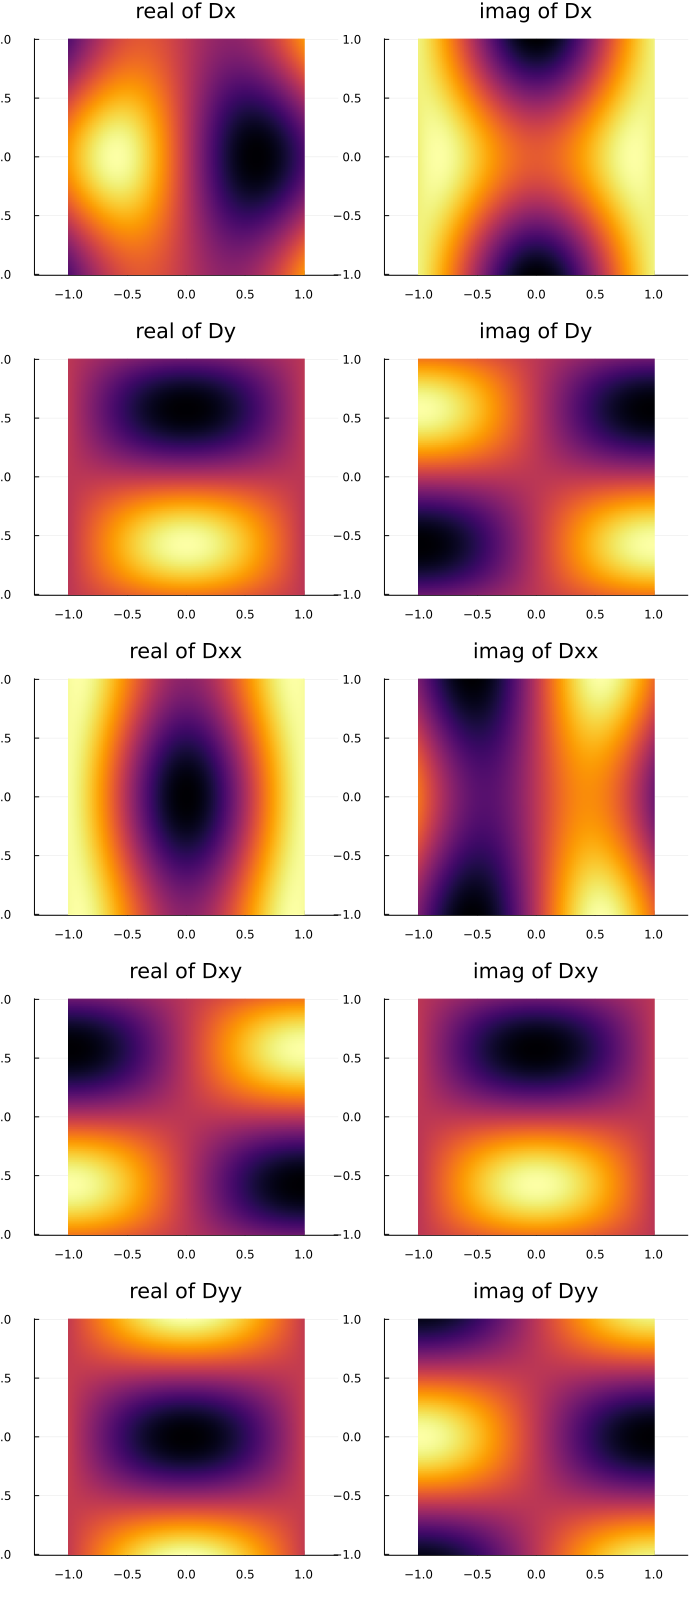

In [11]:
tmp(k -> γ(k[1],k[2]) )